<a href="https://colab.research.google.com/github/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Train_TFLite2_Object_Detction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite Object Detection API in Colab
**Author:** Evan Juras, [EJ Technology Consultants](https://ejtech.io)

**Last updated:** 2/13/25

**GitHub:** [TensorFlow Lite Object Detection](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi)

# Introduction

This notebook uses [the TensorFlow 2 Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to train an SSD-MobileNet model or EfficientDet model with a custom dataset and convert it to TensorFlow Lite format. By working through this Colab, you'll be able to create and download a TFLite model that you can run on your PC, an Android phone, or an edge device like the Raspberry Pi.

> **WARNING:** Google deprecated the TensorFlow Object Detection API over two years ago. For the sake of legacy code, I've kept this training notebook on life support through various hacks and band-aid fixes, and it is prone to stop working at any point. **I will not be providing further support for this video or training notebook.**

> I highly recommend using the newer PyTorch-based Ultralytics YOLO models for object detection. They perform better and they're easier to work with. See my video tutorial on how to train YOLO detection models here: [How to Train YOLO Object Detection Models in Google Colab](https://youtu.be/r0RspiLG260)

<p align=center>
<img src="https://s3.us-west-1.amazonaws.com/evanjuras.com/img/CoinDetectorDemo.gif" height="360"><br>
<i>Custom SSD-MobileNet-FPNLite model in action!</i>
</p>

I also made a YouTube video that walks through this guide step by step. I use a coin detection model as an example for the video. I recommend following along with the video while working through this notebook.

<p align=center>
<a href="https://www.youtube.com/watch?v=XZ7FYAMCc4M" target="_blank"><img src="https://s3.us-west-1.amazonaws.com/evanjuras.com/img/thumbnail-tflite-colab-1.png" height="240"><br>
<i>Click here to go to the video!</i></a>
</p>

**Important note: This notebook will be continuously updated to make sure it works with newer versions of TensorFlow. If you see any differences between the YouTube video and this notebook, always follow the notebook!**

### Working in Colab
Colab provides a virtual machine in your browser complete with a Linux OS, filesystem, Python environment, and best of all, a free GPU. It comes with most TensorFlow backend requirements (like CUDA and cuDNN) pre-installed. Simply click the play button on sections of code in this notebook to execute them on the virtual machine.

> *Note: Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting "GPU" from the Hardware accelerator dropdown.*

This Colab notebook uses TensorFlow 2. If you'd like to use TensorFlow 1, please see my [TF1 Colab notebook](https://colab.research.google.com/github/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Train_TFLite1_Object_Detection_Model.ipynb).

### Navigation
This is a long notebook! Each step of the training process has its own section. Click the arrow next to the heading for each section to expand it. You can use the table of contents in the left sidebar to jump from section to section.

### Fallback Runtime

**IMPORTANT NOTE as of February 13, 2025:** Colab recently upgraded its base version of Python from 3.10 to 3.11, which broke compatibility with this notebook. For now, we can use the "fallback runtime". Please do the following:

1. Initialize the Notebook by clicking "Connect" in the top right corner
2. In the top menu bar, go to Tools -> Command Palette. Search for "fallback runtime" and select "Use fallback runtime version".
3. Continue working through the notebook as normal.

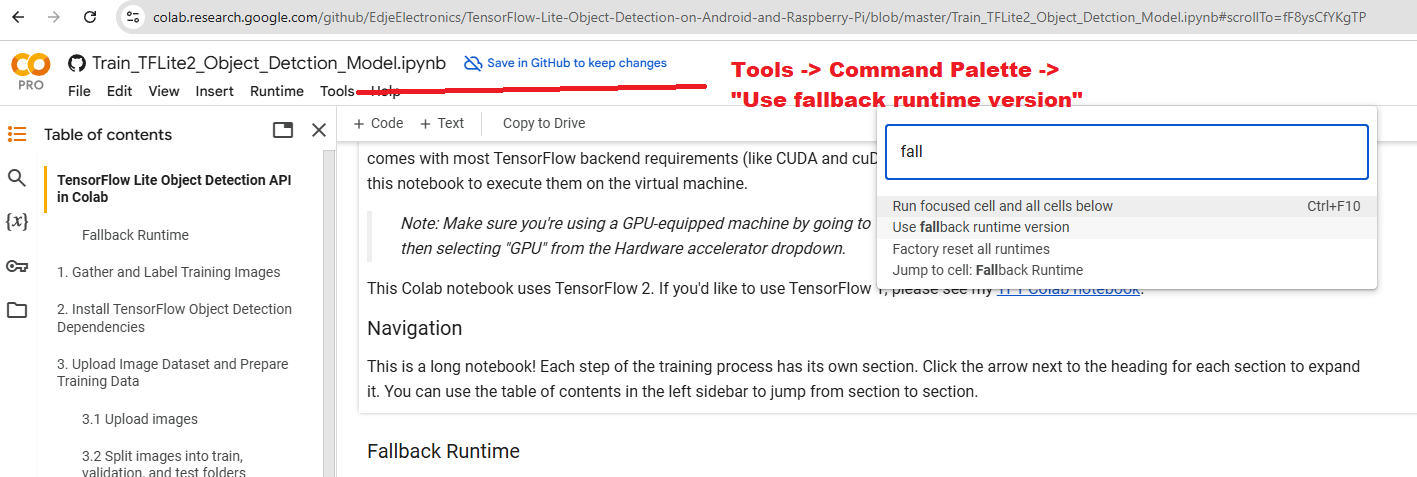

# 1.&nbsp;Gather and Label Training Images

Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

Watch the YouTube video below for instructions and tips on how to gather and label images for training an object detection model.

<p align=center>
<a href="https://www.youtube.com/watch?v=v0ssiOY6cfg" target="_blank"><img src="https://s3.us-west-1.amazonaws.com/evanjuras.com/img/thumbnail-capture-label-data.png" height="240"><br>
<i>Watch this video to learn how to capture and label images.</i></a>
</p>

When you've finished gathering and labeling images, you should have a folder full of images and corresponding .xml data annotation file for each image. An example of a labeled image and the image folder for my coin detector model are shown below.

![](https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/doc/labeled_image_example2.png)

#2.&nbsp;Install TensorFlow Object Detection Dependencies

First, we'll install the TensorFlow Object Detection API in this Google Colab instance. This requires cloning the [TensorFlow models repository](https://github.com/tensorflow/models) and running a couple installation commands. Click the play button to run the following sections of code.

The latest version of TensorFlow this Colab has been verified to work with is TF v2.8.0.



In [ ]:
# Clone the tensorflow models repository from GitHub
!pip uninstall Cython -y # Temporary fix for "No module named 'object_detection'" error
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Copy setup files into models/research folder
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .

In [ ]:
# Modify setup.py file to install the tf-models-official repository targeted at TF v2.8.0
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

When the following code block runs, a window may appear asking to restart the session.

**MAKE SURE THE CODE BLOCK FINISHES EXECUTING BEFORE CLICKING "RESTART SESSION".**

In [ ]:
# Install the Object Detection API (NOTE: This block takes about 10 minutes to finish executing)

# Need to do a temporary fix with PyYAML because Colab isn't able to install PyYAML v5.4.1
!pip install pyyaml==5.3
!pip install /content/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.10 (as of 10/03/22)
!pip install tensorflow==2.8.0
!pip install tensorflow_io==0.23.1

In [ ]:
# Install CUDA version 11.0 (to maintain compatibility with TF v2.8.0)
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget http://developer.download.nvidia.com/compute/cuda/11.0.2/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
!apt-key add /var/cuda-repo-ubuntu1804-11-0-local/7fa2af80.pub
!apt-get update && sudo apt-get install cuda-toolkit-11-0
!export LD_LIBRARY_PATH=/usr/local/cuda-11.0/lib64:$LD_LIBRARY_PATH

You may get warnings or errors related to package dependencies in the previous code block, but you can ignore them for now.

Let's test our installation by running `model_builder_tf2_test.py` to make sure everything is working as expected. Run the following code block and confirm that it finishes without errors. If you get errors, try Googling them or checking the FAQ at the end of this Colab.

In [ ]:
# Set protoc and protobuf to correct versions
!sudo apt-get remove -y protobuf-compiler
!pip install 'protobuf<=3.20.1' --force-reinstall
!wget https://github.com/protocolbuffers/protobuf/releases/download/v3.20.1/protoc-3.20.1-linux-x86_64.zip
!unzip protoc-3.20.1-linux-x86_64.zip -d protoc3
!sudo mv protoc3/bin/* /usr/local/bin/
!sudo mv protoc3/include/* /usr/local/include

In [ ]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


# 3.&nbsp;Upload Image Dataset and Prepare Training Data

In this section, we'll upload our data and prepare it for training with TensorFlow. We'll upload our images, split them into train, validation, and test folders, and then run scripts for creating TFRecords from our data.

First, on your local PC, zip all your training images and XML files into a single folder called "images.zip". The files should be directly inside the zip folder, or in a nested folder as shown below:
```
images.zip
-- images
  -- img1.jpg
  -- img1.xml
  -- img2.jpg
  -- img2.xml
  ...
```

### 3.1 Upload images
There are three options for moving the image files to this Colab instance.

**Option 1. Upload through Google Colab**

Upload the "images.zip" file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

![](https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/doc/colab_upload_button.png)

**Option 2. Copy from Google Drive**

You can also upload your images to your personal Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. This option works well if you want to upload the images beforehand so you don't have to wait for them to upload each time you restart this Colab. If you have more than 50MB worth of images, I recommend using this option.

First, upload the "images.zip" file to your Google Drive, and make note of the folder you uploaded them to. Replace `MyDrive/path/to/images.zip` with the path to your zip file. (For example, I uploaded the zip file to folder called "change-counter1", so I would use `MyDrive/change-counter1/images.zip` for the path). Then, run the following block of code to mount your Google Drive to this Colab session and copy the folder to this filesystem.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/images.zip /content

**Option 3. Use coin detection dataset**

If you don't have a dataset and just want to try training a model, you can download my coin image dataset to use as an example. I've uploaded a dataset containing 750 labeled images of pennies, nickels, dimes, and quarters. Run the following code block to download the dataset.

In [ ]:
!wget -O /content/images.zip https://www.dropbox.com/s/gk57ec3v8dfuwcp/CoinPics_11NOV22.zip?dl=0  # United States coin images

## 3.2 Split images into train, validation, and test folders
At this point, whether you used Option 1, 2, or 3, you should be able to click the folder icon on the left and see your "images.zip" file in the list of files. Now that the dataset is uploaded, let's unzip it and create some folders to hold the images. These directories are created in the /content folder in this instance's filesystem. You can browse the filesystem by clicking the "Files" icon on the left.

In [ ]:
!mkdir /content/images
!unzip -q images.zip -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test

Next, we'll split the images into train, validation, and test sets. Here's what each set is used for:



*   **Train**: These are the actual images used to train the model. In each step of training, a batch of images from the "train" set is passed into the neural network. The network predicts classes and locations of objects in the images. The training algorithm calculates the loss (i.e. how "wrong" the predictions were) and adjusts the network weights through backpropagation.


*   **Validation**: Images from the "validation" set can be used by the training algorithm to check the progress of training and adjust hyperparameters (like learning rate). Unlike "train" images, these images are only used periodically during training (i.e. once every certain number of training steps).


* **Test**: These images are never seen by the neural network during training. They are intended to be used by a human to perform final testing of the model to check how accurate the model is.

I wrote a Python script to randomly move 80% of the images to the "train" folder, 10% to the "validation" folder, and 10% to the "test" folder. Click play on the following block to download the script and execute it.

In [ ]:
!wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/train_val_test_split.py
!python train_val_test_split.py

## 3.3 Create Labelmap and TFRecords
Finally, we need to create a labelmap for the detector and convert the images into a data file format called TFRecords, which are used by TensorFlow for training. We'll use Python scripts to automatically convert the data into TFRecord format. Before running them, we need to define a labelmap for our classes.

The code section below will create a "labelmap.txt" file that contains a list of classes. Replace the `class1`, `class2`, `class3` text with your own classes (for example, `penny`, `nickel`, `dime`, `quarter`), adding a new line for each class. Then, click play to execute the code.

In [ ]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
class1
class2
class3
EOF

Download and run the data conversion scripts from the [GitHub repository](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi) by clicking play on the following three sections of code. They will create TFRecord files for the train and validation datasets, as well as a `labelmap.pbtxt` file which contains the labelmap in a different format.

In [ ]:
# Download data conversion scripts
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py

In [ ]:
# Create CSV data files and TFRecord files
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord

We'll store the locations of the TFRecord and labelmap files as variables so we can reference them later in this Colab session.

In [ ]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'

# 4.&nbsp;Set Up Training Configuration

In this section, we'll set up the model and training configuration. We'll specifiy which pretrained TensorFlow model we want to use from the [TensorFlow 2 Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Each model also comes with a configuration file that points to file locations, sets training parameters (such as learning rate and total number of training steps), and more. We'll modify the configuration file for our custom training job.

The first section of code lists out some models availabe in the TF2 Model Zoo and defines some filenames that will be used later to download the model and config file. This makes it easy to manage which model you're using and to add other models to the list later.

Set the "chosen_model" variable to match the name of the model you'd like to train with. It's currently set to use the popular "ssd-mobilenet-v2" model. Click play on the next block once the chosen model has been set.

Not sure which model to pick? [Check out my blog post comparing each model's speed and accuracy.](https://ejtech.io/learn/tflite-object-detection-model-comparison)

In [ ]:
# Change the chosen_model variable to deploy different models available in the TF2 object detection zoo
chosen_model = 'ssd-mobilenet-v2-fpnlite-320'

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    # The centernet model isn't working as of 9/10/22
    #'centernet-mobilenet-v2': {
    #    'model_name': 'centernet_mobilenetv2fpn_512x512_coco17_od',
    #    'base_pipeline_file': 'pipeline.config',
    #    'pretrained_checkpoint': 'centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz',
    #}
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

Download the pretrained model file and configuration file by clicking Play on the following section.

In [ ]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Download pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download training configuration file for model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

Now that we've downloaded our model and config file, we need to modify the configuration file with some high-level training parameters. The following variables are used to control training steps:

* **num_steps**: The total amount of steps to use for training the model. A good number to start with is 40,000 steps. You can use more steps if you notice the loss metrics are still decreasing by the time training finishes. The more steps, the longer training will take. Training can also be stopped early if loss flattens out before reaching the specified number of steps.
* **batch_size**: The number of images to use per training step. A larger batch size allows a model to be trained in fewer steps, but the size is limited by the GPU memory available for training. With the GPUs used in Colab instances, 16 is a good number for SSD models and 4 is good for EfficientDet models.

Other training information, like the location of the pretrained model file, the config file, and total number of classes are also assigned in this step. To learn more about training configuration with the TensorFlow Object Detection API, read this [article from Neptune](https://neptune.ai/blog/tensorflow-object-detection-api-best-practices-to-training-evaluation-deployment).

In [ ]:
# Set training parameters for the model
num_steps = 40000

if chosen_model == 'efficientdet-d0':
  batch_size = 4
else:
  batch_size = 16

In [ ]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)


Next, we'll rewrite the config file to use the training parameters we just specified. The following section of code will automatically replace the necessary parameters in the downloaded .config file and save it as our custom "pipeline_file.config" file.

In [ ]:
# Create custom configuration file by writing the dataset, model checkpoint, and training parameters into the base pipeline file
import re

%cd /content/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:

    # Set fine_tune_checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set tfrecord files for train and test datasets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # Set label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    # Change fine-tune checkpoint type from "classification" to "detection"
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)

    # If using ssd-mobilenet-v2, reduce learning rate (because it's too high in the default config file)
    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)

      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)

    # If using efficientdet-d0, use fixed_shape_resizer instead of keep_aspect_ratio_resizer (because it isn't supported by TFLite)
    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)


(Optional) If you're curious, you can display the configuration file's contents here in the browser by running the line of code below.

In [ ]:
# (Optional) Display the custom configuration file's contents
!cat /content/models/mymodel/pipeline_file.config

Finally, let's set the locations of the configuration file and model output directory as variables so we can reference them when we call the training command.

In [ ]:
# Set the path to the custom config file and the directory to store training checkpoints in
pipeline_file = '/content/models/mymodel/pipeline_file.config'
model_dir = '/content/training/'

# 5.&nbsp;Train Custom TFLite Detection Model

We're ready to train our object detection model! Before we start training, let's load up a TensorBoard session to monitor training progress. Run the following section of code, and a TensorBoard session will appear in the browser. It won't show anything yet, because we haven't started training. Once training starts, come back and click the refresh button to see the model's overall loss.



In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

Model training is performed using the "model_main_tf2.py" script from the TF Object Detection API. Training will take anywhere from 2 to 6 hours, depending on the model, batch size, and number of training steps. We've already defined all the parameters and arguments used by `model_main_tf2.py` in previous sections of this Colab. Just click Play on the following block to begin training!



> *Note: It takes a few minutes for the program to display any training messages, because it only displays logs once every 100 steps. If it seems like nothing is happening, just wait a couple minutes.*

In [ ]:
# Run training!
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1

If you want to stop training early, just click Stop a couple times or right-click on the code block and select "Interrupt Execution". Otherwise, training will stop by itself once it reaches the specified number of training steps.


# 6.&nbsp;Convert Model to TensorFlow Lite

Alright! Our model is all trained up and ready to be used for detecting objects. First, we need to export the model graph (a file that contains information about the architecture and weights) to a TensorFlow Lite-compatible format. We'll do this using the `export_tflite_graph_tf2.py` script.

In [ ]:
# Make a directory to store the trained TFLite model
!mkdir /content/custom_model_lite
output_directory = '/content/custom_model_lite'

# Path to training directory (the conversion script automatically chooses the highest checkpoint file)
last_model_path = '/content/training'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}


Next, we'll take the exported graph and use the `TFLiteConverter` module to convert it to `.tflite` FlatBuffer format.

In [ ]:
# Convert exported graph file into TFLite model file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect.tflite', 'wb') as f:
  f.write(tflite_model)

# 7.&nbsp;Test TensorFlow Lite Model and Calculate mAP

We've trained our custom model and converted it to TFLite format. But how well does it actually perform at detecting objects in images? This is where the images we set aside in the **test** folder come in. The model never saw any test images during training, so its performance on these images should be representative of how it will perform on new images from the field.

### 7.1 Inference test images
The following code defines a function to run inference on test images. It loads the images, loads the model and labelmap, runs the model on each image, and displays the result. It also optionally saves detection results as text files so we can use them to calculate model mAP score.

This code is based off the [TFLite_detection_image.py](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py) script from my [TensorFlow Lite Object Detection repository on GitHub](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi); feel free to use it as a starting point for your own application.

In [ ]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

      # Save detection results in .txt files (for calculating mAP)
      elif txt_only == True:

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

The next block sets the paths to the test images and models and then runs the inferencing function. If you want to use more than 10 images, change the `images_to_test` variable. Click play to run inferencing!

In [ ]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/images/test'   # Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.5   # Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   # Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

### 7.2 Calculate mAP
Now we have a visual sense of how our model performs on test images, but how can we quantitatively measure its accuracy?

One popular methord for measuring object detection model accuracy is "mean average precision" (mAP). Basically, the higher the mAP score, the better your model is at detecting objects in images. To learn more about mAP, read through this [article from Roboflow](https://blog.roboflow.com/mean-average-precision/).

We'll use the mAP calculator tool at https://github.com/Cartucho/mAP to determine our model's mAP score. First, we need to clone the repository and remove its existing example data. We'll also download a script I wrote for interfacing with the calculator.

In [ ]:
%%bash
git clone https://github.com/Cartucho/mAP /content/mAP
cd /content/mAP
rm input/detection-results/*
rm input/ground-truth/*
rm input/images-optional/*
wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py

Next, we'll copy the images and annotation data from the **test** folder to the appropriate folders inside the cloned repository. These will be used as the "ground truth data" that our model's detection results will be compared to.


In [ ]:
!cp /content/images/test/* /content/mAP/input/images-optional # Copy images and xml files
!mv /content/mAP/input/images-optional/*.xml /content/mAP/input/ground-truth/  # Move xml files to the appropriate folder

The calculator tool expects annotation data in a format that's different from the Pascal VOC .xml file format we're using. Fortunately, it provides an easy script, `convert_gt_xml.py`, for converting to the expected .txt format.



In [ ]:
!python /content/mAP/scripts/extra/convert_gt_xml.py

Okay, we've set up the ground truth data, but now we need actual detection results from our model. The detection results will be compared to the ground truth data to calculate the model's accuracy in mAP.

The inference function we defined in Step 7.1 can be used to generate detection data for all the images in the **test** folder. We'll use it the same as before, except this time we'll tell it to save detection results into the `detection-results` folder.

Click Play to run the following code block!

In [ ]:
# Set up variables for running inference, this time to get detection results saved as .txt files
PATH_TO_IMAGES='/content/images/test'   # Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
PATH_TO_RESULTS='/content/mAP/input/detection-results' # Folder to save detection results in
min_conf_threshold=0.1   # Confidence threshold

# Use all the images in the test folder
image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg') + glob.glob(PATH_TO_IMAGES + '/*.JPG') + glob.glob(PATH_TO_IMAGES + '/*.png') + glob.glob(PATH_TO_IMAGES + '/*.bmp')
images_to_test = min(500, len(image_list)) # If there are more than 500 images in the folder, just use 500

# Tell function to just save results and not display images
txt_only = True

# Run inferencing function!
print('Starting inference on %d images...' % images_to_test)
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)
print('Finished inferencing!')

Finally, let's calculate mAP! One popular style for reporting mAP is the COCO metric for mAP @ 0.50:0.95. Basically, this means that mAP is calculated at several IoU thresholds between 0.50 and 0.95, and then the result from each threshold is averaged to get a final mAP score. [Learn more here!](https://blog.roboflow.com/mean-average-precision/)

I wrote a script to run the calculator tool at each IoU threshold, average the results, and report the final accuracy score. It reports mAP for each class and overall mAP. Click Play on the following two blocks to calculate mAP!

In [ ]:
%cd /content/mAP
!python calculate_map_cartucho.py --labels=/content/labelmap.txt

The score reported at the end is your model's overall mAP score. Ideally, it should be above 50% (0.50). If it isn't, you can increase your model's accuracy by adding more images to your dataset. See my [dataset video](https://www.youtube.com/watch?v=v0ssiOY6cfg) for tips on how to capture good training images and improve accuracy.

# 8.&nbsp;Deploy TensorFlow Lite Model

Now that your custom model has been trained and converted to TFLite format, it's ready to be downloaded and deployed in an application! This section shows how to download the model and provides links to instructions for deploying it on the Raspberry Pi, your PC, or other edge devices.

## 8.1. Download TFLite model

Run the two following cells to copy the labelmap files into the model folder, compress it into a zip folder, and then download it. The zip folder contains the `detect.tflite` model and `labelmap.txt` labelmap files that are needed to run the model in your application.

In [ ]:
# Move labelmap and pipeline config files into TFLite model folder and zip it up
!cp /content/labelmap.txt /content/custom_model_lite
!cp /content/labelmap.pbtxt /content/custom_model_lite
!cp /content/models/mymodel/pipeline_file.config /content/custom_model_lite

%cd /content
!zip -r custom_model_lite.zip custom_model_lite

In [ ]:
from google.colab import files

files.download('/content/custom_model_lite.zip')

The `custom_model_lite.zip` file containing the model will download into your Downloads folder. It's ready to be deployed on your device!

## 8.2. Deploy model
TensorFlow Lite models can run on a wide variety of hardware, including PCs, embedded systems, and phones. This section provides instructions showing how to deploy your TFLite model on various devices.

### 8.2.1. Deploy on Raspberry Pi
TFLite models are great for running on the Raspberry Pi, because they require less processing power than regular TensorFlow vision models. The Pi can run TFLite models in near real-time.

To run your new model on the Raspberry Pi, you'll have to install TensorFlow Lite and prepare a Python environment for your application. I provide step-by-step instructions on how to set up TFLite on the Pi in my video, [How To Run TensorFlow Lite on Raspberry Pi for Object Detection](https://youtu.be/aimSGOAUI8Y).

[![Link to my YouTube video!](https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/doc/YouTube_video1.JPG)](https://www.youtube.com/watch?v=aimSGOAUI8Y)

Once you've completed all the steps in the video, move the `custom_model_lite.zip` file downloaded from this Colab session over to your Raspberry Pi into the `~/tflite1` folder. Move into the folder and unzip it by issuing:

```
cd ~/tflite1
unzip custom_model_lite.zip
```

Then, run the image, video, or webcam TFLite detection program with the `--modeldir=fine_tuned_model_lite` argument. For example, to run the webcam detection program, issue:

```
python TFLite_detection_webcam.py --modeldir=custom_model_lite
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.

### 8.2.2. Deploy on Windows, Linux, or macOS
Follow the instructions linked below to quickly set up your Windows, Linux, or macOS computer to run TFLite models. It only takes a few minutes! Running a model on your PC is good for quickly testing your model with a webcam. However, keep in mind that the TFLite Runtime is optimized for lower-power processors, and it won't utilize the full capability of your PC's processor.

Here are links to the deployment guides for Windows, Linux, and macOS:
* [How to Run TensorFlow Lite Models on Windows](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/deploy_guides/Windows_TFLite_Guide.md)
* *link to Linux guide to be added (but really it's the same as Raspberry Pi)*
* [How to Run TensorFlow Lite Models on macOS](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/deploy_guides/MacOS_TFLite_Guide.md)

### 8.2.3. Deploy on other Linux-based edge devices
Instructions to be added! 🐧

### 8.2.4. Deploy on Android
Instructions to be added! 🤖





# 9.&nbsp;(Optional) Post-Training Quantization

Want to make your TFLite model run even faster? Quantize it! Quantizating a model converts its weights from 32-bit floating-point values to 8-bit integer values. This allows the quantized model to run faster and occupy less memory without too much reduction in accuracy.

> Note: If you observe an obvious decrease in detection accuracy when quantizing your model with TF2, I recommend using TensorFlow 1 to quantize your model instead. TF1 supports quantization-aware training, which helps improve the accuracy of quantized models. The ssd-mobilenet-v2-quantized model from the TF1 Model Zoo has fast and accurate performance when trained with a custom dataset. Visit my [TFLite v1 Colab notebook](https://colab.research.google.com/github/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Train_TFLite1_Object_Detection_Model.ipynb) for step-by-step instructions on how to train and quantize a model with TensorFlow 1.

## 9.1. Quantize model
We'll use the "TFLiteConverter" module to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) on the model. To quantize the model, we need to provide a representative dataset, which is a set of images that represent what the model will see when deployed in the field. First, we'll create a list of images to include in the representative dataset (we'll just use the images in the `train` folder).


In [ ]:
# Get list of all images in train directory
image_path = '/content/images/train'

jpg_file_list = glob.glob(image_path + '/*.jpg')
JPG_file_list = glob.glob(image_path + '/*.JPG')
png_file_list = glob.glob(image_path + '/*.png')
bmp_file_list = glob.glob(image_path + '/*.bmp')

quant_image_list = jpg_file_list + JPG_file_list + png_file_list + bmp_file_list

Next, we'll define a function to yield images from our representative dataset. Refer to [TensorFlow's sample quantization code](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb#scrollTo=kRDabW_u1wnv) to get a better understanding of what this is doing!

In [ ]:
# A generator that provides a representative dataset
# Code modified from https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb

# First, get input details for model so we know how to preprocess images
interpreter = Interpreter(model_path=PATH_TO_MODEL) # PATH_TO_MODEL is defined in Step 7 above
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

import random

def representative_data_gen():
  dataset_list = quant_image_list
  quant_num = 300
  for i in range(quant_num):
    pick_me = random.choice(dataset_list)
    image = tf.io.read_file(pick_me)

    if pick_me.endswith('.jpg') or pick_me.endswith('.JPG'):
      image = tf.io.decode_jpeg(image, channels=3)
    elif pick_me.endswith('.png'):
      image = tf.io.decode_png(image, channels=3)
    elif pick_me.endswith('.bmp'):
      image = tf.io.decode_bmp(image, channels=3)

    image = tf.image.resize(image, [width, height])  # TO DO: Replace 300s with an automatic way of reading network input size
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

Finally, we'll initialize the TFLiteConverter module, point it at the TFLite graph we generated in Step 6, and provide it with the representative dataset generator function we created in the previous code block. We'll configure the converter to quantize the model's weight values to INT8 format.

In [ ]:
# Initialize converter module
converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')

# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input tensors to uint8 and output tensors to float32
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect_quant.tflite', 'wb') as f:
  f.write(tflite_model)

## 9.2. Test quantized model
The model has been quantized and exported as `detect_quant.tflite`. Let's test it out! We'll re-use the function from Section 7 for running the model on test images and display the results, except this time we'll point it at the quantized model.

Click Play on the code block below to test the `detect_quant.tflite` model.

In [ ]:
# Set up parameters for inferencing function (using detect_quant.tflite instead of detect.tflite)
PATH_TO_IMAGES='/content/images/test'   #Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect_quant.tflite'   #Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   #Path to labelmap.txt file
min_conf_threshold=0.5   #Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   #Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

If your quantized model isn't performing very well, try using my TensorFlow Lite 1 notebook *(link to be added)* to train a SSD-MobileNet model with your dataset. In my experience, the `ssd-mobilenet-v2-quantized` model from the [TF1 Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) has the best quantized performance out of any other TensorFlow Lite model.

TFLite models created with TensorFlow 1 are still compatible with the TensorFlow Lite 2 runtime, so your TFLite 1 model will still work with my [TensorFlow setup guide for the Raspberry Pi](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Raspberry_Pi_Guide.md).

## 9.3 Calculate quantized model mAP

Let's calculate the quantize model's mAP using the calculator tool we set up in Step 7.2. We just need to perform inference with our quantized model (`detect_quant.tflite`) to get a new set of detection results.

Run the following block to run inference on the test images and save the detection results.

In [ ]:
# Need to remove existing detection results first
!rm /content/mAP/input/detection-results/*

# Set up variables for running inference, this time to get detection results saved as .txt files
PATH_TO_IMAGES='/content/images/test'   # Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect_quant.tflite'   # Path to quantized .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
PATH_TO_RESULTS='/content/mAP/input/detection-results' # Folder to save detection results in
min_conf_threshold=0.1   # Confidence threshold

# Use all the images in the test folder
image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg') + glob.glob(PATH_TO_IMAGES + '/*.JPG') + glob.glob(PATH_TO_IMAGES + '/*.png') + glob.glob(PATH_TO_IMAGES + '/*.bmp')
images_to_test = min(500, len(image_list)) # If there are more than 500 images in the folder, just use 500

# Tell function to just save results and not display images
txt_only = True

# Run inferencing function!
print('Starting inference on %d images...' % images_to_test)
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)
print('Finished inferencing!')

Now we can run the mAP calculation script to determine our quantized model's mAP.

In [ ]:
cd /content/mAP

In [ ]:
!python calculate_map_cartucho.py --labels=/content/labelmap.txt

## 9.4. Compile model for Edge TPU

Now that the model has been converted to TFLite and quantized, we can compile it to run on Edge TPU devices like the [Coral USB Accelerator](https://coral.ai/products/accelerator/) or the [Coral Dev Board](https://coral.ai/products/dev-board/). This allows the model to run much faster! For information on how to set up the USB Accelerator, my [TensorFlow Lite repository on GitHub](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/deploy_guides/Raspberry_Pi_Guide.md#section-2---run-edge-tpu-object-detection-models-on-the-raspberry-pi-using-the-coral-usb-accelerator).

First, install the Edge TPU Compiler package inside this Colab instance.

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

Next, compile the quantize TFLite model. (If your model has a different filename than "detect_quant.tflite", use that instead.)

In [ ]:
%cd /content/custom_model_lite
!edgetpu_compiler detect_quant.tflite
!mv detect_quant_edgetpu.tflite edgetpu.tflite
!rm detect_quant_edgetpu.log

The compiled model will be output in the `custom_model_lite` folder as "detect__quant_edgetpu.tflite". It gets renamed to "edgetpu.tflite" to be consistent with my code. Zip the `custom_model_lite` folder and download it by running the two code blocks below.

In [ ]:
%cd /content
!zip -r custom_model_lite.zip custom_model_lite

In [ ]:
from google.colab import files

files.download('custom_model_lite.zip')

Now you're all set to use the Coral model! For instructions on how to run an object detection model on the Raspberry Pi using the Coral USB Acclerator, please see my video, ["How to Use the Coral USB Accelerator with the Raspberry Pi"](https://www.youtube.com/watch?v=qJMwNHQNOVU).

# Appendix: Common Errors

Here are solutions to common errors that can occur while stepping through this notebook.

**1. Training suddenly stops with ^C output**

If your training randomly stops without any error messages except a `^C`, that means the virtual machine has run out of memory. To resolve the issue, try reducing the `batch_size` variable in Step 4 to a lower value like `batch_size = 4`. The value must be a power of 2. (e.g. 2, 4, 8 ...)

Source: https://stackoverflow.com/questions/75901898/why-my-model-training-automatically-stopped-during-training